# Hands-On NLP - Class 3: Static Word Embeddings (Word2Vec)

**Goal:** Learn dense vector representations of words.

## Notebook Outline

| Part | Topic | Description |
|------|-------|-------------|
| **1** | Word2Vec from Scratch | Understanding Skip-Gram step by step |
| **2** | Skip-Gram Data Generation | Creating (center, context) training pairs |
| **3** | Training the Model | Forward pass, softmax, backpropagation |
| **4** | Pre-trained Embeddings | Loading and using Gensim Word2Vec |
| **5** | Word Analogies | King - Man + Woman = ? |
| **6** | Bias in Embeddings | Detecting and understanding learned biases |
| **7** | Visualizing Embeddings | PCA projection to 2D |

**Key Concepts:**
- Dense vs. sparse representations
- Skip-Gram architecture (predict context from center word)
- Cosine similarity for word relationships
- Analogies and bias in learned embeddings

<span style="color:magenta">Student name:</span>

* 🚧
- Edna Iusupova
- Dominika


In [70]:
import collections
import re
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.spatial
import seaborn as sns
from tqdm.notebook import tqdm

# Sklearn for visualization
from sklearn.decomposition import PCA

# Setup
tqdm.pandas()
sns.set_style("darkgrid")
sns.set_context("notebook")
pd.set_option("display.precision", 4)

## Part 1: Why Word Embeddings?

**The Problem with Sparse Vectors (TF-IDF, BoW):**
- "cat" and "dog" are equally distant as "cat" and "democracy"
- No notion of semantic similarity

**Word Embeddings:** Dense vectors where similar words are close!

```
Sparse (one-hot):  cat = [0,0,0,1,0,0,...,0]  (10,000 dims, one 1)
                   dog = [0,0,1,0,0,0,...,0]  (orthogonal to cat!)

Dense (embedding): cat = [0.2, -0.5, 0.8, ...]  (100-300 dims)
                   dog = [0.3, -0.4, 0.7, ...]  (similar to cat!)
```

**The Key Insight:** Words that appear in similar contexts have similar meanings.
> "You shall know a word by the company it keeps" — J.R. Firth (1957)

### ❓ Question 1

Why do we say that sparse vectors (like One-Hot or TF-IDF) have no notion of semantic similarity?
*Hint: What happens if you calculate the dot product or Euclidean distance between the vectors for "cat" and "dog" in a one-hot encoding?*

**Answer:**
Sparse vectors (One-Hot) lack semantic similarity because:
- Mathematical Orthogonality: Every word is represented as a unique dimension. Therefore, the dot product of any two different word vectors (like "cat" and "dog") is always 0.

- Equal Distance: In this vector space, all words are at the exact same Euclidean distance from each other.


### 1.1 Skip-Gram vs CBOW

Word2Vec has two architectures:

| Architecture | Input | Output | Intuition |
|--------------|-------|--------|-----------|
| **Skip-Gram** | Center word | Context words | "Given 'cat', predict 'the', 'sat', 'on', 'mat'" |
| **CBOW** | Context words | Center word | "Given 'the', 'sat', 'on', 'mat', predict 'cat'" |

```
Sentence: "The cat sat on the mat"
          
Skip-Gram (window=2):
  Center: "cat" → Predict: "The", "sat"
  Center: "sat" → Predict: "cat", "on"

CBOW (window=2):
  Context: ["The", "sat"] → Predict: "cat"
  Context: ["cat", "on"] → Predict: "sat"
```

We'll implement **Skip-Gram** as it works better for rare words.

## Part 2: Building a Toy Vocabulary

Let's start with a tiny corpus to understand the mechanics.

**🚧 TODO:** Tokenize text and build word↔index mappings.

In [71]:
TOY_CORPUS = """What is a word embedding?
A word vector (or embeddings) is a dense representation,
which captures semantic relationships between words."""

def tokenize(text):
    return re.findall(r"\w+", text.lower())

tokens = tokenize(TOY_CORPUS)

# 🚧 TODO: Build Vocabulary (word -> index and index -> word)
def build_vocab(tokens, show_df=False):
    # Using Pandas to visualize frequency - helpful for checking Zipf's law!
    #TODO
    word_counts = Counter(tokens)
    sorted_vocab = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    w2i = {word: i for i, (word, count) in enumerate(sorted_vocab)}
    i2w = {i: word for word, i in w2i.items()}
    if show_df:
        df = pd.DataFrame(sorted_vocab, columns=['word', 'count'])
        print("Vocabulary DataFrame:")
        print(df)
    return w2i, i2w

w2i, i2w = build_vocab(tokens, show_df=True)
vocab_size = len(w2i)
print(f"Vocab size: {vocab_size}")


Vocabulary DataFrame:
              word  count
0                a      3
1               is      2
2             word      2
3             what      1
4        embedding      1
5           vector      1
6               or      1
7       embeddings      1
8            dense      1
9   representation      1
10           which      1
11        captures      1
12        semantic      1
13   relationships      1
14         between      1
15           words      1
Vocab size: 16


### ❓ Question 2

We used `re.findall(r"\w+", text.lower())`.
1. What does `.lower()` do and why is it common in simple NLP tasks?
2. What happens to punctuation marks like `?` or `,` with this regex?
3. Pros/Cons: Is removing punctuation always a good idea? (Think about "I.T." vs "it").


## Part 3: Generating Skip-Gram Training Pairs

For each word in the corpus, we create (center, context) pairs.

**Example with window=2:**
```
"what is a word embedding"
  │
  └─► center="word" (index 3)
      contexts: "is"(1), "a"(2), "embedding"(4)
      
      Training pairs: (3,1), (3,2), (3,4)
```

**🚧 TODO:** Implement the pair generation function.

In [72]:
def generate_skip_data(tokens, window_size, w2i):
    xs, ys = [], []
    for i, word in enumerate(tokens):
        center_idx = w2i[word]
        start = max(0, i - window_size)
        end = min(len(tokens), i + window_size + 1)

        for j in range(start, end):
            if i == j: continue
            xs.append(center_idx)
            ys.append(w2i[tokens[j]])

    return np.array(xs), np.array(ys)

xs, ys = generate_skip_data(tokens, window_size=2, w2i=w2i)
print(f"Generated {len(xs)} pairs.")
print("Example:", xs[:5], ys[:5])

Generated 74 pairs.
Example: [3 3 1 1 1] [1 0 3 0 2]


### ❓ Question 3

Imagine a sentence with 10 words.
If we use **Skip-Gram** with `window_size=2`:
1. How many pairs are generated for the 5th word (which has full context on both sides)?
2. How many pairs in total (roughly)?
3. How does this compare to CBOW? (See next section)


### 3.1 Alternative: Continuous Bag of Words (CBOW)

For the calculation of word2vec we also have the **CBOW** (Continuous Bag of Words) method as an alternative to Skip-Gram.

- **Skip-Gram**: Predict context from center.
- **CBOW**: Predict center from sum/average of context.

Our training pairs `(xs, ys)` will be structurally different:
- `xs`: List of context word indices.
- `ys`: Index of the center word.

**🚧 TODO:** Implement the CBOW data generation.


In [73]:
def generate_cbow_data(tokens, window_size, w2i):
    xs, ys = [], []
    for i, word in enumerate(tokens):
        # 🚧 TODO : complete the code to fill xs and ys.
        target_idx = w2i[word]
        start = max(0, i - window_size)
        end = min(len(tokens), i + window_size + 1)
        context_indices = []
        for j in range(start, end):
            if i == j:
                continue
            context_indices.append(w2i[tokens[j]])
        if context_indices:
            xs.append(context_indices)
            ys.append(target_idx)

    return xs, ys

## Part 4: The Skip-Gram Model Architecture

**The Neural Network:**

```
Input (one-hot)      Embedding Matrix        Context Matrix        Softmax
     ↓                    W                      W'                  ↓
 [0,0,1,0,0]    →    lookup row 2    →    dot product    →    probabilities
   (vocab_size)         (emb_size)       (emb_size, vocab)      (vocab_size)
```

**What we learn:**
- $W$ : Embedding matrix (vocab_size × emb_size) - **This is what we keep!**
- $W'$ : Context matrix (emb_size × vocab_size) - Usually discarded

**🚧 TODO:** Initialize the weight matrices randomly.

In [74]:
EMB_SIZE = 10

# 🚧 TODO: Initialize parameters
parameters = {
    "W": np.random.randn(vocab_size, EMB_SIZE) * 0.1,
    "W_prime": np.random.randn(EMB_SIZE, vocab_size) * 0.1
}
print("Initialized weights.")

Initialized weights.


### ❓ Question 4
🚧 TODO: Answer the following questions:
1. Why must they be randomly initialized?
2. What happens if all are initialized to zero?

## Part 4.1: Helper Functions (Softmax & Cross Entropy)

Before training, we need our activation and loss functions.

**1. Softmax**: Converts raw output scores ($z$) into probabilities ($p$).
$$ \text{softmax}(z_i) = \frac{e^{z_i}}{\sum_j e^{z_j}} $$

**2. Cross Entropy**: Measures the difference between predicted probabilities and the true target.
$$ J = - \sum y_i \log(p_i) $$


🚧 TODO: Implement softmax:
Requirements:
- Must be numerically stable
- Input shape (batch_size, vocab_size)
- Output shape: same as input  
🚧 TODO: Implement Cross-Entropy loss
Requirements:
- Input: softmax probabilities
- Target:index of correct word
- Return scalar loss

In [75]:
# 🚧 TODO: Implement Softmax and cross-entropy

def softmax(zs):
    # subtract max for numerical stability (prevents overflow)
    # Compute exponentials
    # Normalize
    shift_zs = zs - np.max(zs, axis=1, keepdims=True)
    exp_zs = np.exp(shift_zs)
    probs = exp_zs / np.sum(exp_zs, axis=1, keepdims=True)
    return probs

def cross_entropy(softmax_out, ys):
    # Select the probabilities corresponding to the true labels
    # Compute negative log likelihood
    # Return mean loss
    batch_size = softmax_out.shape[0]
    corect_word_probs = softmax_out[np.arange(batch_size), ys]
    loss = -np.log(corect_word_probs + 1e-10)

    return loss


### ❓ Question 5

In the `softmax` function, it is standard practice to compute `exps = np.exp(zs - np.max(zs))`.
Why do we subtract the maximum value?
*Hint: Try calculating `np.exp(1000)` in a new cell.*


## Part 4.2: Forward & Backward Propagation

**Forward Pass**:
1. Look up embeddings for input words ($X$).
2. Multiply by context matrix ($W'$).
3. Apply Softmax.

**Backward Pass**:
1. Calculate error ($P - Y$).
2. Propagate gradients back to $W'$ and $X$.


🚧 TODO: Implement CBOW forward and backpropagation
Implement:
1. Forward pass
2. Gradient computation
3. Parameter updates using SGD

In [76]:
def cbow_forward_propagation(context_indices, W, W_prime):
    # TODO:
    # 1. Compute hidden representation
    # 2. Compute logits
    # 3. Apply softmax
    hidden = np.mean(W[context_indices], axis=0, keepdims=True)
    zs = np.dot(hidden, W_prime)
    probs = softmax(zs)
    return probs, hidden

def cbow_backward_propagation(context_indicies, target_index, probs, hidden, W, W_prime, lr):

    #TODO:
    # 1. Compute output error
    # 2. Update W_prime
    # 3. Update embeddings in W
    error = probs.copy()
    error[0, target_index] -= 1

    grad_W_prime = np.dot(hidden.T, error)
    W_prime -= lr * grad_W_prime
    grad_hidden = np.dot(error, W_prime.T)
    for idx in context_indicies:
        W[idx] -= lr * (grad_hidden.ravel() / len(context_indicies))

### ❓ Question 6

**CBOW vs Skip-Gram Architectures:**
1. In CBOW, we average (or sum) the context embeddings to get a hidden layer. Does this operation preserve the **order** of words in the context?
2. Does "The dog bit the man" produce a different context sum than "The man bit the dog" (assuming window covers full sentence)?
3. Why might Skip-Gram be computationally more expensive than CBOW?


🚧 TODO: Implement Skip-gram forward and backpropagation
Implement gradient updates for:
- Input word embeddings
- Output embeddings of context words


In [77]:
#🚧 TODO: Implement CBOW forward and backpropagation
def skipgram_forward_propagation(center_index, W, W_prime):
    # TODO
    hidden = W[center_index].reshape(1, -1)
    zs = np.dot(hidden, W_prime)
    probs = softmax(zs)
    return probs, hidden

def skipgram_backward_propagation(center_index, target_index, probs, hidden, W, W_prime, lr):
    #TODO
    error = probs.copy()
    error[0, target_index] -= 1
    grad_W_prime = np.dot(hidden.T, error)
    grad_hidden = np.dot(error, W_prime.T)
    W_prime -= lr * grad_W_prime
    W[center_index] -= lr * grad_hidden.ravel()

### ❓ Question 7

🚧 TODO: Answer the following questions:
1. Compare the gradient flow in CBOW vs Skipgram.
2. What is the computational bottleneck of full softmax backprop?


## Part 4.3: The Training Loop

Now we put it all together with Stochastic Gradient Descent (SGD)!

🚧 TODO: In this section, you will integrate all components implemented so far to train CBOW and Skip-gram models end-to-end.
You must :
- Initialize parameters
- Iterate over training examples
- Perform forward propagation
- Compute loss
- Perform backward propagation
- Update parameters


Training Skip-Gram...


Training Skip-Gram:   0%|          | 0/500 [00:00<?, ?it/s]

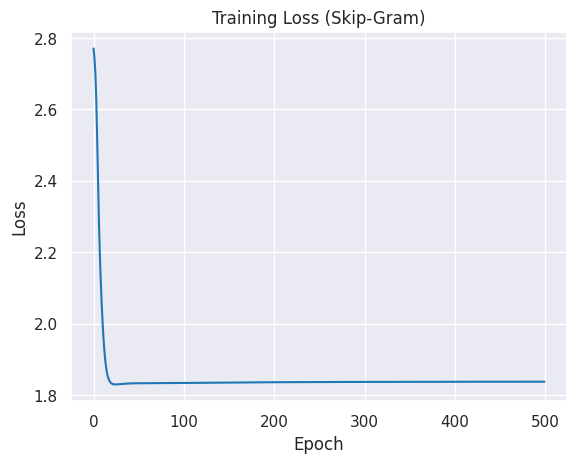

In [88]:
def train_cbow_model(training_data, vocab_size, emb_size=10, epochs=100, lr=0.1):
    parameters = {
        "W": np.random.randn(vocab_size, emb_size) * 0.1,
        "W_prime": np.random.randn(emb_size, vocab_size) * 0.1
    }
    W = parameters["W"]
    W_prime = parameters["W_prime"]

    xs, ys = training_data
    losses = []

    for epoch in tqdm(range(epochs), desc="Training CBOW"):
        epoch_loss = 0.0

        for i in range(len(xs)):
            context = xs[i]
            target = int(ys[i])

            probs, hidden = cbow_forward_propagation(context, W, W_prime)
            loss = cross_entropy(probs, target)
            epoch_loss += float(np.mean(loss))

            cbow_backward_propagation(context, target, probs, hidden, W, W_prime, lr)

        losses.append(epoch_loss / max(1, len(xs)))

    return parameters, losses


def train_skipgram_model(training_data, vocab_size, emb_size=10, epochs=100, lr=0.1):
    parameters = {
        "W": np.random.randn(vocab_size, emb_size) * 0.1,
        "W_prime": np.random.randn(emb_size, vocab_size) * 0.1
    }
    W = parameters["W"]
    W_prime = parameters["W_prime"]

    xs, ys = training_data
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Skip-Gram"):
        epoch_loss = 0.0

        for i in range(len(xs)):
            center = int(xs[i])
            target = int(ys[i])

            probs, hidden = skipgram_forward_propagation(center, W, W_prime)
            loss = cross_entropy(probs, target)
            epoch_loss += float(np.mean(loss))

            skipgram_backward_propagation(center, target, probs, hidden, W, W_prime, lr)

        losses.append(epoch_loss / max(1, len(xs)))

    return parameters, losses


# Run Training
print("Training Skip-Gram...")
final_params, loss_history = train_skipgram_model((xs, ys), vocab_size, emb_size=EMB_SIZE, epochs=500)

plt.plot(loss_history)
plt.title("Training Loss (Skip-Gram)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


## Part 5: Using Pre-trained Embeddings (Gensim)

Training Word2Vec from scratch requires massive data and time.
Instead, we use pre-trained embeddings!

**Popular Pre-trained Embeddings:**
| Name | Training Data | Dimensions |
|------|--------------|------------|
| Word2Vec | Google News (100B words) | 300 |
| GloVe | Wikipedia + Gigaword (6B) | 50-300 |
| FastText | Wikipedia + Common Crawl | 300 |

We'll use a smaller file: `enwiki-50k_100d.txt` (50k words, 100 dimensions)

In [89]:
# Option 1: Load from Gensim (downloads ~66MB on first run)
# import gensim.downloader as api
# model = api.load("glove-wiki-gigaword-50")

# Option 2: Load from local file (faster, smaller)
def read_vectors(filepath="enwiki-50k_100d.txt", vocab_size=50000, dimension=100):
    """
    Read pre-computed embeddings from a text file.
    Format: each line is "word val1 val2 val3 ..."

    Returns:
        w2i: dict mapping word -> index
        i2w: dict mapping index -> word
        embeddings: numpy array of shape (vocab_size, dimension)
    """
    embeddings = np.zeros((vocab_size, dimension))
    w2i, i2w = {}, {}

    with open(filepath, "r", encoding="utf-8") as f:
        for i, line in enumerate(tqdm(f, total=vocab_size, desc="Loading embeddings")):
            parts = line.strip().split()
            word = parts[0]
            vector = np.array(parts[1:], dtype=np.float32)

            w2i[word] = i
            i2w[i] = word
            embeddings[i] = vector

            if i >= vocab_size - 1:
                break

    print(f"Loaded {len(w2i)} words with {dimension} dimensions.")
    return w2i, i2w, embeddings

# Load the embeddings
try:
    w2i, i2w, embeddings = read_vectors()
except FileNotFoundError:
    print("⚠️ Embedding file not found. Using Gensim instead...")
    import gensim.downloader as api
    model = api.load("glove-wiki-gigaword-50")
    w2i = {w: i for i, w in enumerate(model.index_to_key)}
    i2w = {i: w for i, w in enumerate(model.index_to_key)}
    embeddings = model.vectors

Loading embeddings:   0%|          | 0/50000 [00:00<?, ?it/s]

Loaded 50000 words with 100 dimensions.


In [90]:
# Normalize embeddings for cosine similarity
# Cosine similarity of unit vectors = dot product (much faster!)
normed_embeddings = embeddings / (np.linalg.norm(embeddings, axis=1, keepdims=True) + 1e-10)

print(f"Embeddings shape: {embeddings.shape}")
print(f"First 5 words: {[i2w[i] for i in range(5)]}")
print(f"Sample vector (first 10 dims): {embeddings[0, :10]}")

Embeddings shape: (50000, 100)
First 5 words: ['the', 'in', 'of', 'a', 'and']
Sample vector (first 10 dims): [-0.0811      0.51450002  0.0368      0.0544     -0.0662      0.2121
  0.1636     -0.1011      0.0607     -0.1858    ]


### ❓ Question 9

**Normalization:**
We divided each vector by its L2 norm (`np.linalg.norm`).
1. What is the length (magnitude) of every vector after this operation?
2. If we didn't normalize, how would it affect the Cosine Similarity calculation?
3. How would it affect Euclidean Distance?


### 5.1 Finding Similar Words

**Cosine Similarity:** Measures the angle between two vectors.
$$ \cos(\theta) = \frac{\vec{a} \cdot \vec{b}}{|\vec{a}| |\vec{b}|} $$

For normalized vectors: $\cos(\theta) = \vec{a} \cdot \vec{b}$ (just dot product!)

**🚧 TODO:** Find the most similar words to a given word.

In [91]:
def find_closest_words(word, k=10):
    """Find the k most similar words to the input word."""
    # TODO
    if word not in w2i:
        print(f"Word '{word}' not in vocabulary.")
        return []

    query_vec = normed_embeddings[w2i[word]]
    similarities = np.dot(normed_embeddings, query_vec)
    top_indices = np.argsort(similarities)[-(k+1):][::-1]

    results = []
    for idx in top_indices:
        target_word = i2w[idx]
        if target_word == word:
            continue
        results.append((target_word, similarities[idx]))

    return results[:k]

def pretty_print(results):
    """Pretty print word similarity results."""
    for word, sim in results:
        print(f"  {word:15s} {sim:.3f}")
    print()

# Test it!
print("Words most similar to 'king':")
pretty_print(find_closest_words("king"))

print("Words most similar to 'computer':")
pretty_print(find_closest_words("computer"))

Words most similar to 'king':
  kings           0.762
  monarch         0.760
  queen           0.757
  prince          0.731
  throne          0.723
  reign           0.710
  regent          0.701
  ruler           0.696
  conqueror       0.695
  vi              0.685

Words most similar to 'computer':
  computers       0.858
  mainframe       0.782
  software        0.780
  computing       0.778
  microcomputer   0.766
  hardware        0.762
  programmable    0.739
  graphics        0.729
  programmer      0.727
  simulation      0.725



## Part 6: Word Analogies

The famous property of Word2Vec: linear relationships!

$$ \vec{king} - \vec{man} + \vec{woman} \approx \vec{queen} $$

```
        MAN ─────────── WOMAN
         │               │
    (royalty)       (royalty)
         │               │
        KING ─────────── QUEEN
              (gender)
```

**🚧 TODO:** Implement the analogy function.

In [82]:
def find_analogy(word_a, word_b, word_c, k=5):
    """
    Find word D such that: A is to B as C is to D

    Formula: vec(D) ≈ vec(B) - vec(A) + vec(C)

    Example: king is to man as queen is to woman
             find_analogy("man", "king", "woman") → "queen"
    """

    for w in [word_a, word_b, word_c]:
        if w not in w2i:
            print(f"Word '{w}' not in vocabulary.")
            return []
    va = normed_embeddings[w2i[word_a]]
    vb = normed_embeddings[w2i[word_b]]
    vc = normed_embeddings[w2i[word_c]]

    target_vec = vb - va + vc

    # Compute similarities (dot product)
    # We don't strictly need to normalize target_vec for ranking,
    # but it's good practice if we wanted exact cosine scores.
    similarities = np.dot(normed_embeddings, target_vec)

    # Get top indices
    top_indices = np.argsort(similarities)[::-1]

    results = []
    input_words = {word_a, word_b, word_c}

    for idx in top_indices:
        word = i2w[idx]
        # Skip the input words themselves to avoid trivial answers
        if word in input_words:
            continue

        results.append((word, similarities[idx]))
        if len(results) >= k:
            break

    return results

# Classic examples
print("man : king :: woman : ?")
pretty_print(find_analogy("man", "king", "woman"))

print("paris : france :: tokyo : ?")
pretty_print(find_analogy("france", "paris", "japan"))

print("slow : slower :: fast : ?")
pretty_print(find_analogy("slow", "slower", "fast"))

man : king :: woman : ?
  queen           0.928
  monarch         0.829
  consort         0.805
  regent          0.793
  princess        0.769

paris : france :: tokyo : ?
  tokyo           0.930
  osaka           0.878
  yokohama        0.860
  kyoto           0.846
  nagoya          0.845

slow : slower :: fast : ?
  faster          0.915
  quicker         0.831
  slowest         0.781
  nimble          0.705
  quieter         0.701



## Part 7: Bias in Word Embeddings

⚠️ **Important:** Embeddings learn biases from their training data!

Since Word2Vec is trained on text written by humans, it captures human biases:
- Gender stereotypes
- Racial biases  
- Cultural assumptions

**🚧 TODO:** Measure the bias between professions and gender.

In [83]:
def cosine_similarity(word1, word2):
    """Calculate cosine similarity between two words."""
    if word1 not in w2i or word2 not in w2i:
        return None
    vec1 = normed_embeddings[w2i[word1]]
    vec2 = normed_embeddings[w2i[word2]]
    return np.dot(vec1, vec2)

def measure_bias(word, gender_pair=("man", "woman")):
    """
    Measure how much a word is biased toward one gender vs another.
    Positive = more similar to first word (e.g., "man")
    Negative = more similar to second word (e.g., "woman")
    """
    # TODO
    man, woman = gender_pair
    sim_man = cosine_similarity(word, man)
    sim_woman = cosine_similarity(word, woman)

    if sim_man is None or sim_woman is None:
        return None

    return sim_man - sim_woman


# Analyze profession biases
professions = ["doctor", "nurse", "engineer", "teacher", "programmer",
               "secretary", "scientist", "receptionist", "pilot", "librarian"]

print("Profession Gender Bias Analysis")
print("(positive = more 'man', negative = more 'woman')")
print("-" * 45)

for profession in professions:
    bias = measure_bias(profession)
    if bias is not None:
        direction = "→ man" if bias > 0 else "→ woman"
        bar = "█" * int(abs(bias) * 50)
        print(f"{profession:15s} {bias:+.3f} {direction:10s} {bar}")

Profession Gender Bias Analysis
(positive = more 'man', negative = more 'woman')
---------------------------------------------
doctor          -0.053 → woman    ██
nurse           -0.218 → woman    ██████████
engineer        +0.079 → man      ███
teacher         -0.160 → woman    ███████
programmer      +0.035 → man      █
secretary       -0.046 → woman    ██
scientist       +0.014 → man      
receptionist    -0.153 → woman    ███████
pilot           +0.021 → man      █
librarian       -0.188 → woman    █████████


In [84]:
# The controversial "nurse" analogy
print("\n🚨 The problematic 'nurse' analogy:")
print("man : doctor :: woman : ?")
pretty_print(find_analogy("man", "doctor", "woman"))

print("woman : nurse :: man : ?")
pretty_print(find_analogy("woman", "nurse", "man"))


🚨 The problematic 'nurse' analogy:
man : doctor :: woman : ?
  midwife         0.881
  obstetrician    0.844
  nurse           0.815
  dentist         0.800
  physician       0.795

woman : nurse :: man : ?
  medic           0.756
  sgt             0.701
  fireman         0.690
  vet             0.664
  firefighter     0.659



### ❓ Question 10

**Debiasing:**
Biases in embeddings can amplify real-world discrimination in downstream applications (like resume screening comparisons).
1. How could we mathematically remove the gender component from the vector "doctor"?
   *Hint: Think about the vector `v_gender = v_man - v_woman`.*
2. Should we remove bias from *all* words? What about "king" and "queen" or "grandmother"?


## Part 8: Visualizing Word Embeddings

Let's project our high-dimensional embeddings (100D) down to 2D for visualization using PCA.

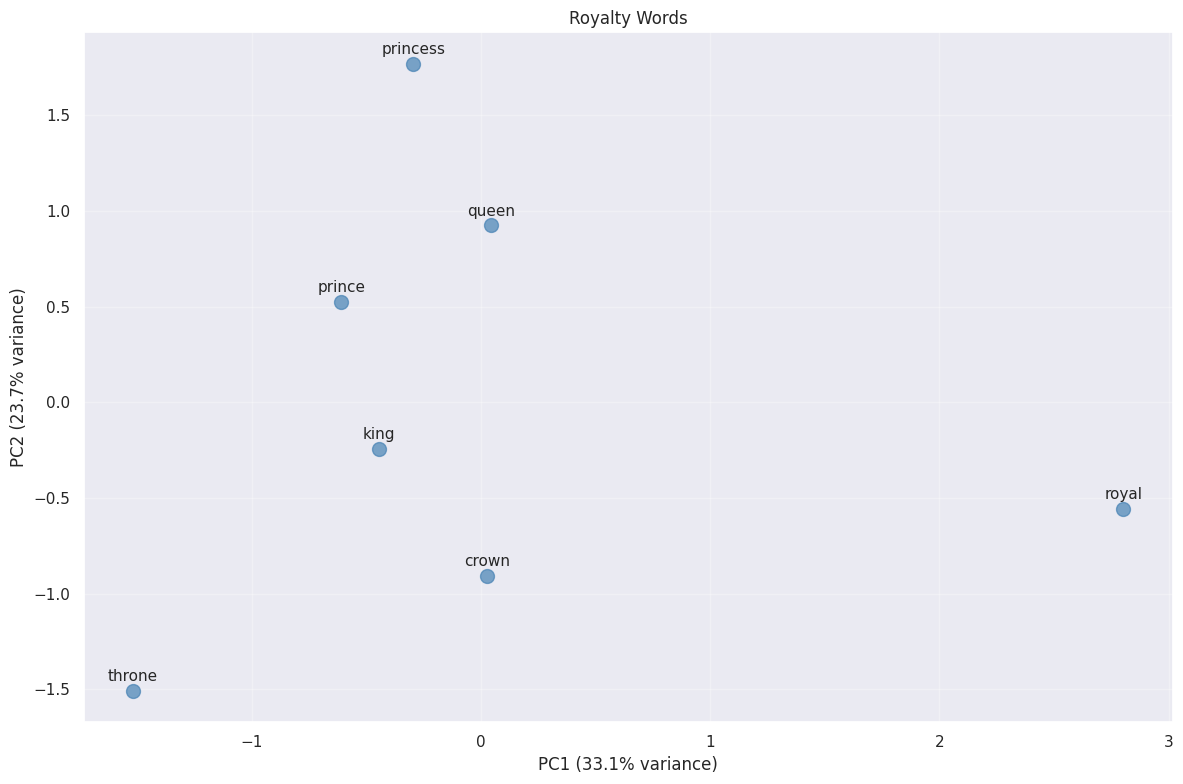

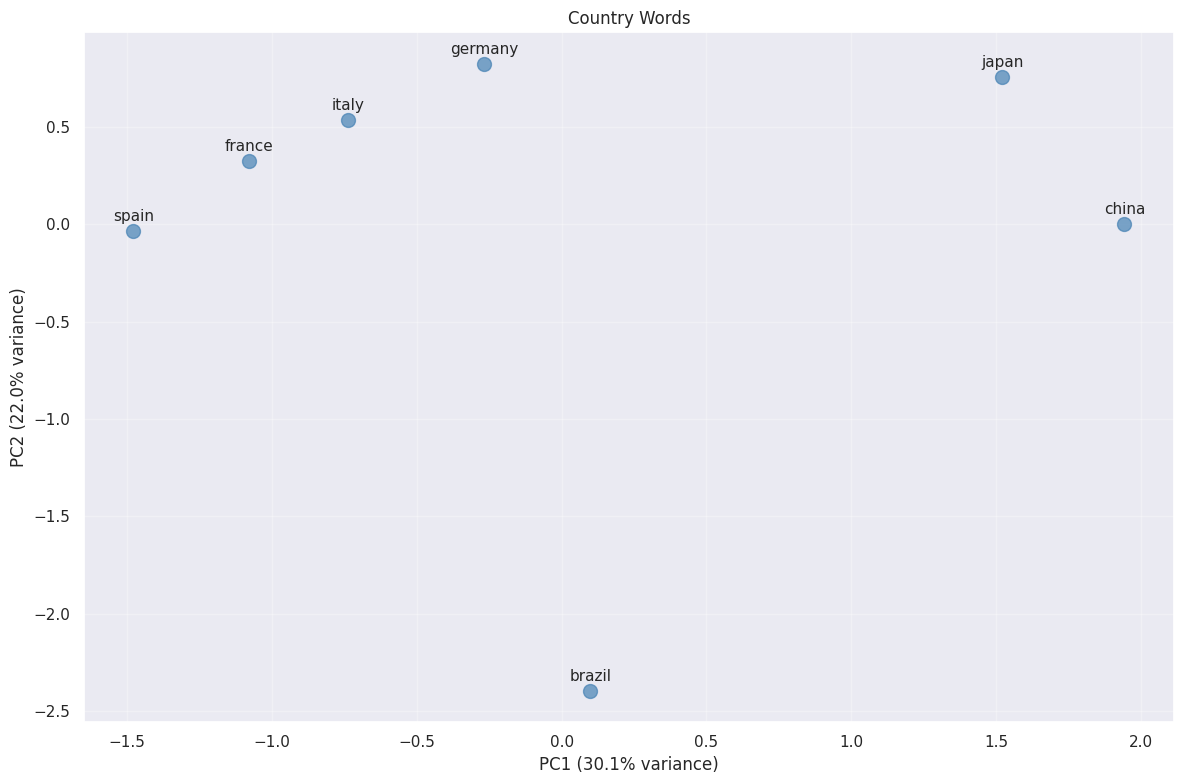

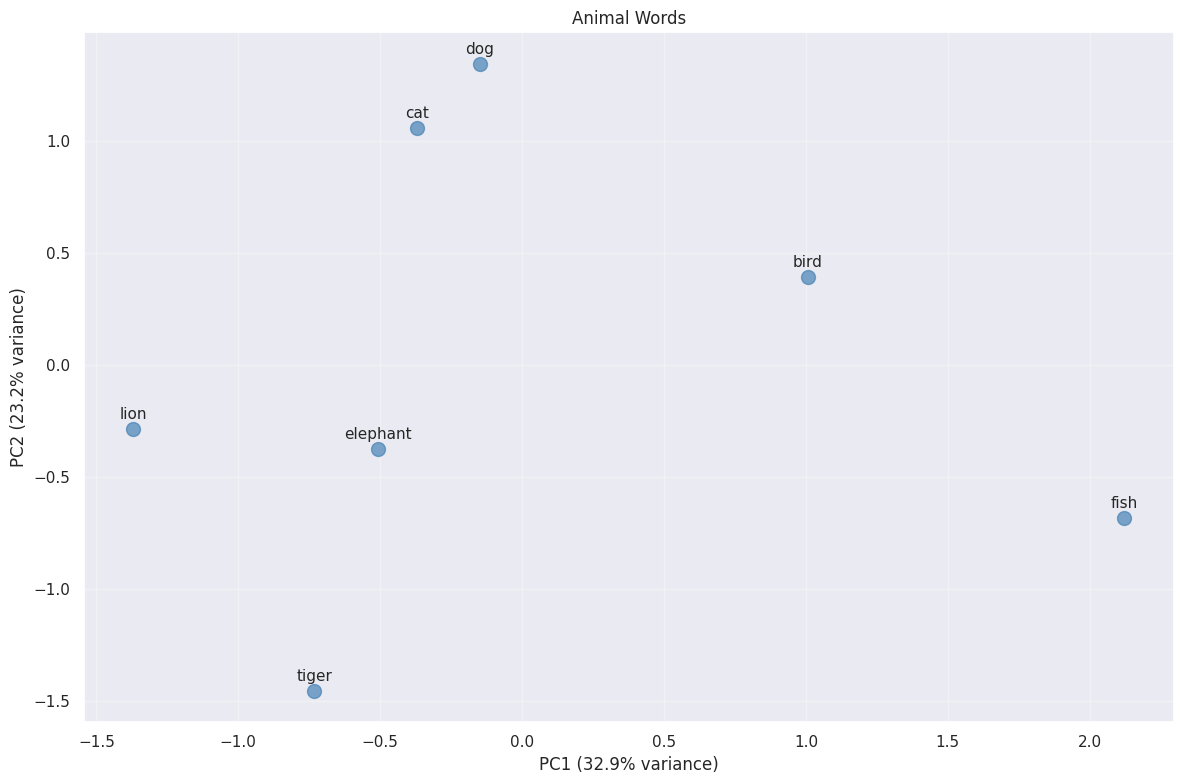

In [85]:
def plot_words(words, title="Word Embeddings (PCA to 2D)"):
    """Plot words in 2D space using PCA."""
    # Get word vectors
    valid_words = [w for w in words if w in w2i]
    if len(valid_words) == 0:
        print("No valid words found!")
        return

    vectors = np.array([embeddings[w2i[w]] for w in valid_words])

    # PCA to 2D
    pca = PCA(n_components=2)
    coords = pca.fit_transform(vectors)

    # Plot
    plt.figure(figsize=(12, 8))
    plt.scatter(coords[:, 0], coords[:, 1], c='steelblue', s=100, alpha=0.7)

    for i, word in enumerate(valid_words):
        plt.annotate(word, (coords[i, 0], coords[i, 1]),
                     fontsize=11, ha='center', va='bottom',
                     xytext=(0, 5), textcoords='offset points')

    plt.title(title)
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Visualize related word groups
royalty = ["king", "queen", "prince", "princess", "royal", "throne", "crown"]
countries = ["france", "germany", "italy", "spain", "japan", "china", "brazil"]
animals = ["dog", "cat", "lion", "tiger", "elephant", "bird", "fish"]

plot_words(royalty, "Royalty Words")
plot_words(countries, "Country Words")
plot_words(animals, "Animal Words")

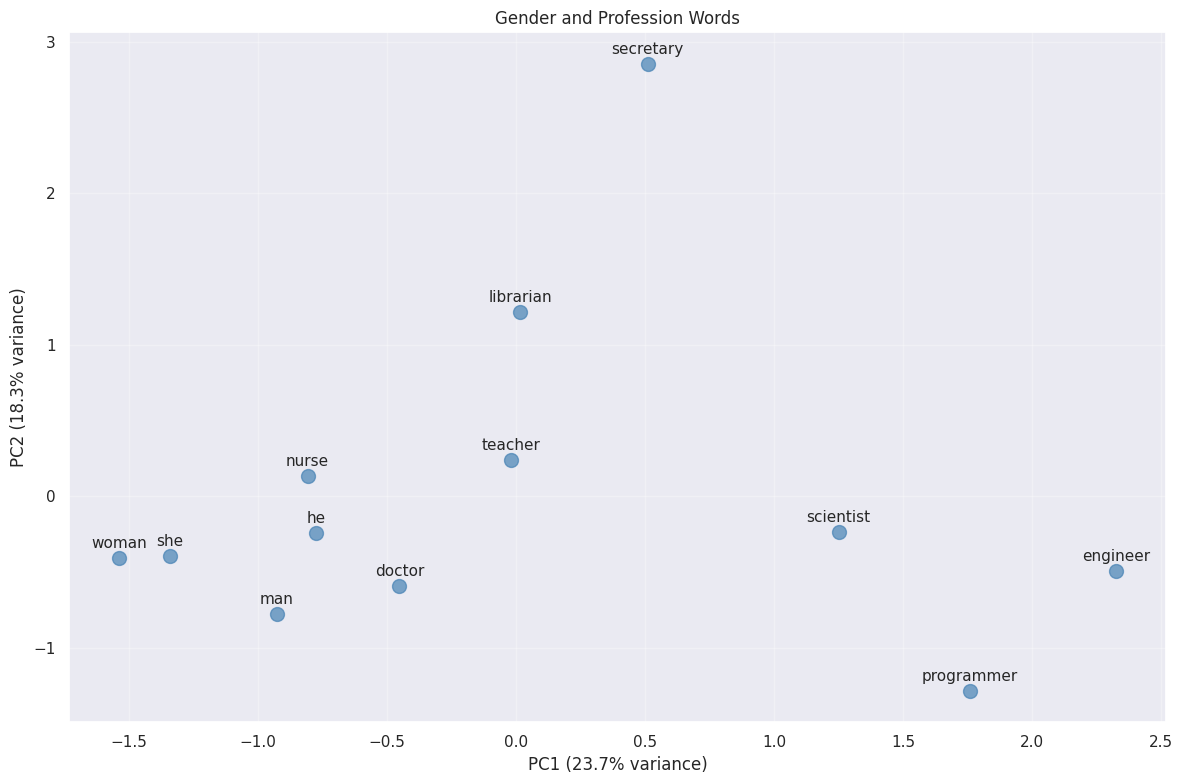

In [86]:
# Visualize the gender-profession relationship
gender_profession_words = [
    "man", "woman", "he", "she",
    "doctor", "nurse", "engineer", "teacher",
    "programmer", "secretary", "scientist", "librarian"
]
plot_words(gender_profession_words, "Gender and Profession Words")

## Part 9: From Word Vectors to Document Vectors

How do we represent an entire document using word embeddings?

**Simple approach:** Average all word vectors in the document.

$$ \vec{doc} = \frac{1}{n} \sum_{i=1}^{n} \vec{word_i} $$

This is surprisingly effective for many tasks!

### ❓ Question 11

**Averaging Word Vectors:**
If "excellent" is `[0.8, 0.2]` and "terrible" is `[-0.8, -0.2]`, what happens if we average them?
Does the resulting vector represent "average opinion" or "no opinion"?
What is the risk of using simple averaging for Sentiment Analysis?


In [87]:
import re

def doc_to_vec(text):
    """
    Convert a document to a single vector by averaging word vectors.
    Only includes words that are in our vocabulary.
    """
    # Simple tokenization
    tokens = re.findall(r'\w+', text.lower())

    # Get vectors for words in vocabulary
    vectors = [embeddings[w2i[t]] for t in tokens if t in w2i]

    if len(vectors) == 0:
        return np.zeros(embeddings.shape[1])

    # Average and normalize
    doc_vec = np.mean(vectors, axis=0)
    doc_vec = doc_vec / (np.linalg.norm(doc_vec) + 1e-10)

    return doc_vec

def find_similar_docs(query_text, doc_texts, doc_labels, k=3):
    """Find the most similar documents to a query."""
    query_vec = doc_to_vec(query_text)

    similarities = []
    for text in doc_texts:
        doc_vec = doc_to_vec(text)
        sim = np.dot(query_vec, doc_vec)
        similarities.append(sim)

    top_indices = np.argsort(similarities)[-k:][::-1]

    return [(doc_labels[i], similarities[i]) for i in top_indices]

# Test with some example texts
documents = [
    "The king and queen lived in a beautiful castle.",
    "Python programming is useful for data science.",
    "Cats and dogs are popular pets around the world.",
    "Machine learning algorithms need lots of data.",
    "The princess wore a golden crown at the ceremony."
]
labels = ["royalty1", "programming", "animals", "ML", "royalty2"]

query = "The royal family attended the coronation"
print(f"Query: '{query}'\n")
print("Most similar documents:")
for label, sim in find_similar_docs(query, documents, labels):
    print(f"  {label}: {sim:.3f}")

Query: 'The royal family attended the coronation'

Most similar documents:
  royalty2: 0.849
  royalty1: 0.823
  animals: 0.647


## Summary & Key Takeaways

### What We Learned

| Concept | Key Insight |
|---------|-------------|
| **Distributional Semantics** | "You shall know a word by the company it keeps" - context defines meaning |
| **Skip-Gram** | Predicts context words from target word → learns word representations |
| **Dense Vectors** | 100-300 dimensions capture semantic relationships (vs sparse 10,000+ TF-IDF) |
| **Pre-trained Embeddings** | GloVe/Word2Vec trained on billions of words → transfer learning |
| **Cosine Similarity** | Measures semantic closeness: $\cos(\theta) = \frac{\vec{A} \cdot \vec{B}}{||\vec{A}|| \cdot ||\vec{B}||}$ |
| **Word Analogies** | Vector arithmetic: king - man + woman ≈ queen |
| **Bias Detection** | Embeddings inherit societal biases from training data |
| **Document Vectors** | Simple averaging of word vectors → document representation |

### Limitations of Static Word Embeddings

1. **One vector per word**: "bank" (river) and "bank" (financial) have the same embedding
2. **Out-of-vocabulary**: Unknown words have no embedding
3. **No context sensitivity**: Meaning doesn't adapt to surrounding words

### Next Steps (Notebook 4+)

- **Subword embeddings**: FastText handles OOV words with character n-grams
- **Contextual embeddings**: BERT, GPT → different embeddings based on context
- **Fine-tuning**: Adapt pre-trained embeddings to domain-specific tasks

### ❓ Question 12 (Final Reflection)

**Polysemy (Multiple Meanings):**
Static embeddings (Word2Vec, GloVe) assign exactly one vector per word in the vocabulary.
Consider the word **"Apple"**.
1. If the training data contains "Apple pie" (fruit) and "Apple iPhone" (company) in equal amounts, what will the vector for "Apple" look like?
2. Will it be close to "Pear"? Will it be close to "Microsoft"?
3. How does this limit the model's ability to understand specific sentences?
